
## `lab07`—Waves and Harmonies

## Objectives

-   Utilize NumPy to construct and solve a numerical system.
-   Apply the finite difference method to solve the wave equation in one dimensions.
-   Utilize SciPy (new library) for special functions useful in solving the wave equation in two dimensions.
-   There are 6 questions to answer.

Double-click here to list collaborators' or partners' **StudentIDs** here:  ☐

The ancient Greek Pythagoras believed that numbers and *ratios* had special powers and could reveal the laws of nature (like fengshui or I-Ch'ng).  According to the legend, he discovered the ratios of musical notes by listening to the vibrations of strings of different lengths, and launched the theoretical exploration of both music and pure mathematics.

In today's lab, we will explore harmonics and numerically solve certain cases of string and plate harmonics using NumPy and SciPy.  As we will use these throughout, first we'll go ahead and import the libraries:

In [3]:
# Make sure that you run this cell to import the necessary libraries.
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
mpl.rcParams['figure.figsize'] = 7,7

### Simple String Harmonics

A plucked string vibrates.  This is a simple observation, but how much of music depends on it!  We're going to model how vibrations travel as waves through a string, just like these vibrations:

<img src="https://upload.wikimedia.org/wikipedia/commons/0/00/Vibration_corde_trois_modes.gif" width="400px;"/>

Vibrations are waves, and as such they are governed by the *wave equation*.  We'll numerically solve this equation for a string and then for a plate, which will give you an idea how basic numerical algorithms work in Python.  Details are shared in an appendix to this lab.

#### Governing Equations

We write the *wave equation* to describe how it moves in space given certain *boundary conditions*  The boundary conditions specify that the string ends are secured, or *fixed*.  For a $1 \,\text{m} \times 1 \,\text{m}$ plate,

$$
\frac{\partial^2 u}{\partial t^2} - c^2 \frac{\partial^2 u}{\partial x^2} = 0
\hspace{5cm}
\begin{eqnarray}
u(0, t) = 0 \\
u(1, t) = 0
\end{eqnarray}
$$

$u$ describes the position of the string at location $x$ at time $t$.  The wave equation means that the propagation of a disturbance (a wave) in *time* can be related to its propagation in space via the speed of travel $c$.  That's just what the second derivatives do in this equation.

We'll use the *finite difference method* (FDM) to numerically solve this problem.  You will learn this during your Year Two mathematics class. In FDM, one converts a differential equation over a continuous space to a matrix equation over a grid.

![](./img/fdm.png)

(As you can see, one consequence of this is that we will only have solutions at particular points rather than everywhere.  Some error is necessarily introduced in this process.)

After some derivation, we numerically solve the equation

$$
\frac{u^{n+1}_{i} - 2u^{n}_{i} + u^{n-1}_{i}}{\Delta t^2} - c^2 \frac{u^{n}_{i+1} - 2u^{n}_{i} + u^{n}_{i-1}}{\Delta x^2} = 0
\hspace{2cm}
\begin{eqnarray}
u^n_0 = 0 \\
u^n_{i_{\max}} = 0
\end{eqnarray} \,\text{.}
$$

or, for a single grid point,

$$
u^{n+1}_{i} = \left( \frac{c^2 \Delta t^2}{\Delta x^2} \right) \left( u^{n}_{i+1} + u^{n}_{i-1} \right) + 2 \left( 1 - \left( \frac{c^2 \Delta t^2}{\Delta x^2} \right) \right) u^{n}_{i} - u^{n-1}_{i} \,\text{.}
$$

$\Delta t$ and $\Delta x$ represent the time step size and distance between two grid points, respectively.
$u^{n+1}_{i}$ is the position of the string at position i at future time step which is n+1 (see `unew` below).
$u^{n}_{i}$ is the position of the string at position i at current time which is n (see `u` below).
$u^{n-1}_{i}$ is the position of the string at position i at previous time step which is n-1 (see `uold` below).

That looks scarely, doesn't it?  Let's see what's going on.

Basically, we've created a grid describing a string.  We then have a way of relating the *current* ($n$) and *past* ($n-1$) points together to predict the *next step* point ($n+1$).  This equation just tells us what the proportions of the other grid values should be in order to obtain an estimate of $u^{n+1}_{i}$. The vertical direction gives the different points in time, the horizontal direction gives the different points along the string.

![](./img/fdm-stencil.png)

#### Implementation

First let's define the broad parameters of our simulation.  Any time we want to run this simulation for slightly different circumstances, these are the values we need to revisit.

-   Create the following variables.  Include appropriate comments.

| Variable | Value  | Purpose |
| -------- | ------ | ------- |
| `c`      | `0.01`  | wave velocity |
| `tmax`      | `10.0` | maximum time |
| `nt`     | `1000` | number of time steps (total) |
| `xmin`   | `0.0`  | minimum $x$-coordinate |
| `xmax`   | `1.0`  | maximum $x$-coordinate |
| `nx`     | `250`  | number of grid coordinates |
| `dt`     | $\frac{t}{n_t}$ | size of time step |
| `dx`     | $\frac{x_{\max} - x_{\min}}{n_x}$ | size of grid coordinates |

In [4]:
##########################################################################
#####################  Question 1 (16 points) ############################
##########################################################################

'''
Initialize all variables given from the table.
'''
c = 0.01 # wave velocity
tmax = 10.0 # max time
nt   = 1000 # number of steps
xmin = 0.0 # min x coord
xmax = 1.0 # max x coord
nx   = 250 # number of grid coords
dt   = tmax/nt # size of step
dx   = (xmax - xmin)/nx # size of grid coord

In [5]:
# your code should pass these tests---do NOT edit this cell
from numpy import isclose
assert type(c)    == float and c    == 0.01
assert type(tmax) == float and tmax == 10.0
assert type(nt)   == int   and nt   == 1000
assert type(xmin) == float and xmin == 0.0
assert type(xmax) == float and xmax == 1.0
assert type(nx)   == int   and nx   == 250
assert isclose(dt, 0.01)
assert isclose(dx, 0.004)
print('Success!')

Success!


We need a few things to track the data for our numerical solver to work.  We'll use NumPy arrays to store our grid values.  Making a grid is straightforward with `np.linspace` and `np.zeros`.

-   $u_n$ will represent the current time step.
-   $u_{n-1}$ represents the previous time step; call it `uold`.
-   $u_{n+1}$ represents the next time step; call it `unew`.

The function [`np.zeros`](https://docs.scipy.org/doc/numpy/reference/generated/numpy.zeros.html) accepts a *length* and returns an array of that size.  The function [`np.linspace`](https://docs.scipy.org/doc/numpy/reference/generated/numpy.linspace.html) will also be useful in defining the $x$ values from `xmin` to `xmax`, with `nx+1` points to generate `nx` intervals.

-   Define the following array variables.  These should be sufficient to store all grid values as well as the left and right boundary conditions.  For this purpose, they should have `nx+1` points.

| Variable | Explanation | Initial Condition |
| -------- | ----------- | ----------------- |
| `uold`   | store past grid values (representing time step $i-1$) | all zeroes, of size $n_x+1$ |
| `u`      | store current grid values (representing time step $i$) | all zeroes, of size $n_x+1$ |
| `unew`   | store future grid values (representing time step $i+1$) | all zeroes, of size $n_x+1$ |
| `x`      | $x$ positions along grid, $x_i$ | from `xmin` to `xmax`, of size $n_x+1$ |

In [6]:
##########################################################################
#####################  Question 2 (16 points) ############################
##########################################################################

#  Create your array variables here.
uold = np.zeros((nx+1,))
u = np.zeros((nx+1,))
unew = np.zeros((nx+1,))
x = np.linspace(xmin,xmax,nx+1)

In [7]:
# your code should pass these tests---do NOT edit this cell
from numpy import isclose
assert type( u )    == np.ndarray and u.shape    == ( nx+1, ) and u[ 10 ]    == 0.0
assert type( uold ) == np.ndarray and uold.shape == ( nx+1, ) and uold[ 10 ] == 0.0
assert type( unew ) == np.ndarray and unew.shape == ( nx+1, ) and unew[ 10 ] == 0.0
assert type( x )    == np.ndarray and x.shape    == ( nx+1, ) and isclose( x[ 10 ],0.04 )
print( 'Success!' )

Success!


We now require an initial condition.  We didn't specify that previously; let's use

$$
u(x, 0) = sin(2 \pi x)
$$

which satisfies the boundary conditions as well.

-   Initialize `u` to the initial condition; you may use the `np.sin` function and `np.pi`.  Make `uold` equal to a *copy* of `u` (*i.e.*, use the `copy` method); this is necessary to make sure that you have two separate arrays rather than two names for the same array.

In [8]:
##########################################################################
#####################  Question 3 (8 points) ############################
##########################################################################

'''
Initialize u and uold.  This will overwrite your previous creation, but should be the same size.
Use x to calculate u; uold can be a *copy* of u.
Think:  why don't we need to initialize unew?
''' 
u = np.sin(2*np.pi*x)
uold = u.copy()

In [9]:
# your code should pass these tests---do NOT edit this cell
from numpy import isclose
assert isclose( u[ 0 ],0.0 ) and isclose( u[ -1 ],0.0 ) and isclose( u[ 1 ],0.0251301 )
assert ( u == uold ).all() and uold is not u
print( 'Success!' )

Success!


Finally we're ready for the *main loop*.  This is a very common pattern in numerical codes:  set up the equation and variables, then progressively solve the equation for each time step moving through the entire simulation.

Recall the equation we're interested in solving for each data point:

$$
u^{n+1}_{i} = \left( \frac{c^2 \Delta t^2}{\Delta x^2} \right) \left( u^{n}_{i+1} + u^{n}_{i-1} \right) + 2 \left( 1 - \left( \frac{c^2 \Delta t^2}{\Delta x^2} \right) \right) u^{n}_{i} - u^{n-1}_{i} \,\text{.}
$$

You can see that `unew` is $u^{n+1}_{i}$, `u` is $u^{n}_{i}$, and `uold` is $u^{n-1}_{i}$.

$u^{n+1}_{i}$ is the position of the string at position i at future time step which is n+1 (represented as `unew[i]`).

$u^{n}_{i+1}$ is the position of the string at position i+1 at current time step which is n (represented as `u[i+1]`).

$u^{n}_{i-1}$ is the position of the string at position i-1 at current time step which is n (represented as `u[i-1]`).

$u^{n}_{i}$ is the position of the string at position i at current time which is n (represented as `u[i]`).

$u^{n-1}_{i}$ is the position of the string at position i at previous time step which is n-1 (represented as `uold[i]`).

Hence, as the time passes, the new position of the i-th point on the string depends on `unew[i]`, `u[i+1]`, `u[i-1]`, `u[i]`, and `uold[i]`.

First, let's rewrite this in NumPy terms (for an index `i` which we haven't defined yet):

    s = c**2 * dt**2 / dx**2
    unew[ i ] = s * ( u[ i+1 ] + u[ i-1 ] ) + 2*( 1-s )*u[ i ] - uold[ i ]

Since we're going to solve this for many time steps $n$, we need to carry out the following process for each `n`.

-   Create a loop which follows the above process.

    0.  Loop over each time step `n` in the range from `n=0` to `n=nt-1`.
    1.  Loop over each spatial index `i` from one to `nx-1`.  This preserves the boundary conditions of zero at indices `i=0` and `i=nx`.
    1.  Calculate the value of `unew`.
    2.  Change the value of `uold` to the current value of `u` (a copy).
    3.  Change the value of `u` to the current value of `unew` (a copy).

In [10]:
##########################################################################
#####################  Question 4 (20 points) ############################
##########################################################################
'''
Simulate the wave until the end of time. Copy the u and uold from above to here before you start`
'''
u = np.sin(2*np.pi*x)
uold = u.copy()
s = c**2 * dt**2 / dx**2
#  Define your main numerical loop here.
#  1. Loop over each time step in the range from n=0 to n=nt-1.
#  This loop changes the time step n so that you can get the waveform at different time
for n in range(0, nt):
    #  2. Loop over each spatial index from i=1 to i=nx-1. This preserves
    #     the boundary conditions of zero at indices i=0 and i=nx.
    #  This solves the new positions of all the points (all the i) on the string
    for i in range(1, nx):   
        #  3. Calculate the value of unew.
        unew[ i ] = s * ( u[ i+1 ] + u[ i-1 ] ) + 2*( 1-s )*u[ i ] - uold[ i ]

    #  4. Change the value of uold to the current value of u (using copy).
    uold = u.copy()

    #  5. Change the value of u to the current value of unew (using copy).
    u = unew.copy()
#  You should now have an array u which contains the current position of the wave at time n=nt.

In [11]:
# your code should pass these tests---do NOT edit this cell
from nose.tools import assert_equal, assert_is_not

assert type( u )    == np.ndarray and u.shape    == ( nx+1, )
assert type( uold ) == np.ndarray and uold.shape == ( nx+1, )
assert type( unew ) == np.ndarray and unew.shape == ( nx+1, )

assert_equal( np.isclose( uold[ 2 ],4.06582729e-02 ),True, msg="\nYour array `uold` seems to be off." )
assert_equal( np.isclose( u[ 2 ],   4.06397178e-02 ),True, msg="\nYour array `u` seems to be off." )
assert_equal( np.isclose( unew[ 2 ],4.06397178e-02 ),True, msg="\nYour array `unew` seems to be off (at this point, it should be equal to `u`." )

print('Success!')

Success!


Now plot the *results* of the equation solution.

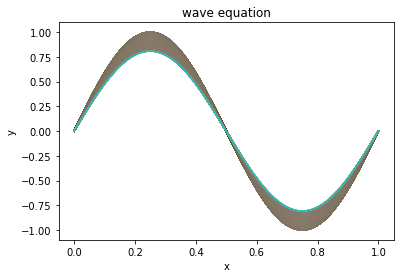

In [31]:
##########################################################################
#####################  Question 5 (12 points) ############################
##########################################################################
'''
Simulate the wave.  Copy the loop from above.
After EACH iteration of simulation, plot u.
'''
for n in range(0, nt):
    for i in range(1, nx):
            unew[ i ] = s * ( u[ i+1 ] + u[ i-1 ] ) + 2*( 1-s )*u[ i ] - uold[ i ]
    plt.plot(x,unew)
    uold = u.copy()
    u = unew.copy()
plt.xlabel('x')
plt.ylabel('y')
plt.title('wave equation')
#  1. Plot the values of x, unew (make sure your arguments to plt.plot() are in the correct order).
#     You may use any line style you like ('b-', 'r--', etc.).
    #  2. Loop over each spatial index from one to nx-1. This preserves
    #     the boundary conditions of zero at indices i=0 and i=nx+1.
        #  3. Calculate the value of unew.
        #  4. Change the value of uold to the current value of u (using copy).
        #  5. Change the value of u to the current value of unew (using copy).
#  2. Add labels to the x-axis 'x' and the y-axis 'y', as well as a title 'wave equation'.


# Don't use plt.show(), as it messes up the autograder.
test_axes = plt.gca()

In [32]:
# your code should pass these tests---do NOT edit this cell
from nose.tools import assert_equal, assert_is_not
import matplotlib as mpl

assert_equal( isinstance( test_axes,mpl.axes.Axes ),True, msg="\nYour code does not create a plot." )
assert_equal( len( test_axes.get_lines() ),1000,msg="\nYour plot does not have the correct number of lines.  (Did you plt.show() it?  You shouldn't.)" )

print( 'Success!' )

Success!


### Plate Harmonics

The beat of a drum or the crash of cymbals relies on more than one-dimensional vibration.  Higher-order harmonics become necessary to describe shapes pulsing or vibrating in higher dimensions.  German physicist Ernst Chladni devised [a clever means of discovering these shapes empirically](https://infogalactic.com/info/Ernst_Chladni#Chladni_figures):  coat the surface with a thin layer of sand, which concentrates when the plate is struck on the vibrational nodes (or stationary parts of the wave).  Dramatic and beautiful pictures can be obtained.  ([Videos](https://youtu.be/1yaqUI4b974) are also available (might not be so available in China).

![](https://i.ytimg.com/vi/wMIvAsZvBiw/hqdefault.jpg)

![](https://static.squarespace.com/static/549dcda5e4b0a47d0ae1db1e/54a06d6ee4b0d158ed95f696/54a06d70e4b0d158ed9602ae/1378862083897/1000w/Chladni_patterns.png)

The mathematical theory of the wave equation underlying this effect in two and three dimensions is now well-understood, and we can use simple assumptions to calculate the modes of vibration for square and circular plates.  Arbitrary shapes require heavier-duty numerics to obtain.

#### Governing Equations

<div class="alert alert-info">
*We don't actually have to solve the wave equation to obtain the Chladni patterns.*  We already know that the lines of sand concentrate at the standing nodes, where the amplitude is zero always.  Therefore we can simply set the form of the equation equal to zero and solve for the lines where this condition holds:

$$
  a \sin\left( \pi n x \right) \sin\left( \pi m y \right)
+ b \sin\left( \pi m x \right) \sin\left( \pi n y \right)
= 0
$$

This will be automatically done by making a *contour plot* of the answer, since there will be a contour at height $u = 0$.

There are four parameters we can set in this equation—$a$, $b$, $m$, $n$—before we can solve for $x$ and $y$.  $a = b = +1$ is a reasonable starting point, but feel free to play around with these values as well.

-   Compose a function `chladni` which accepts as parameters `a`, `b`, `m`, `n`.  `chladni` should return a plot of the solution.  (We return it from the function so we can test it for correctness below.)  Use the following code outline to guide your code.

In [35]:
##########################################################################
#####################  Question 6 (16 points) ############################
##########################################################################

def chladni( a,b,m,n ):
    '''
    Plot Chladni graph with given parameters.
    Args:
        a, b, m, n: arbitrary int numbers for generation
    Returns:
        plot
    '''
    
    npts = 101  # set the number of grid points to 101
    
    # Set up coordinate grids in x and y from -1 to +1 with npts intervals in each.  Use NumPy's linspace.
    x = np.linspace(-1,1,npts)
    y = np.linspace(-1,1,npts)
    
    # Set up a solution 2D-grid u of size (npts, npts).  Use NumPy's zeros or empty.
    u = np.zeros((npts,npts))
    
    # Solve the equation for each point of the grid in x and y.
    # You'll need to import NumPy to get sin and pi.
    for ix in range( npts ):
        for iy in range( npts ):
            u[ ix,iy ] = a*np.sin(np.pi*n*x[ix])*np.sin(np.pi*m*y[iy])+b*np.sin(np.pi*m*ix)*np.sin(np.pi*n*iy)
    
    #asin(πnx)sin(πmy)+bsin(πmx)sin(πny)=0

    # This is a contour plot with one curve and a 5-pixel-thick line.
    plot = plt.contour( x,y,u,0,linewidths=5 )
    
    # Plots are confusing.  But for the kind of plot we want (a contour plot),
    # we have to set the x and y labels like this:
    plot.ax.set_xlabel( 'x' )
    # Set a y label as well:
    plot.ax.set_ylabel( 'y' )
    # Title the plot 'Chladni plot':
    plot.ax.set_title( 'Chladni plot' )
    
    return plot

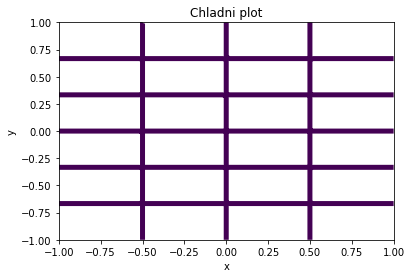

In [36]:
# feel free to test your code here---try lots of values for the parameters!
# you can try to reproduce many of the shapes in the diagram below
chladni( 10,9,2,3 )

![](https://static.squarespace.com/static/549dcda5e4b0a47d0ae1db1e/54a06d6ee4b0d158ed95f696/54a06d70e4b0d158ed9602ae/1378862083897/1000w/Chladni_patterns.png)

All tests passed successfully.


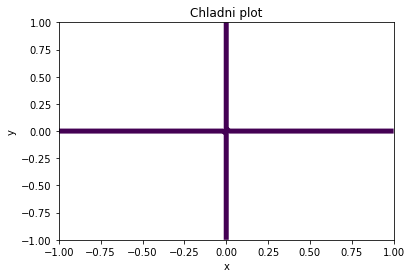

In [37]:
# it should pass this test---do NOT edit this cell
import matplotlib as mpl
from nose.tools import assert_equal, assert_is_not

test_axes = chladni( -7,4,1,1 )

assert_equal( isinstance( test_axes,mpl.contour.QuadContourSet ),True,msg="\nYour function does not return a contour plot." )

print( 'All tests passed successfully.' )

All tests passed successfully.


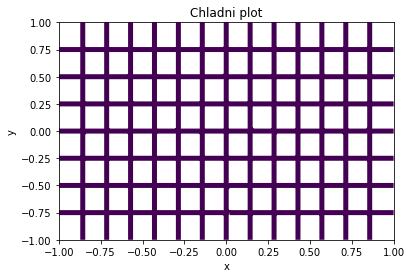

In [38]:
# it should pass this test---do NOT edit this cell
import matplotlib as mpl
from nose.tools import assert_equal, assert_is_not

test_axes = chladni( 1,1,-7,4 )

assert_is_not( len( test_axes.ax.get_xlabel() ),0,msg="\nYour plot does not have labels on the x-axis." )
assert_is_not( len( test_axes.ax.get_ylabel() ),0,msg="\nYour plot does not have labels on the y-axis." )

print( 'All tests passed successfully.' )

# Before you submit...

### Submission [12 points]
Make sure that you have filled your name and studentID as well as answered all the 6 questions.

Save this file as lab07-studentID.ipynb then UPLOAD to RELATE!

## Appendix (extra information on how to get to the finite difference equation)
### Governing Equations for String Vibration

Although you don't need to know differential equations to complete this lab, a little background will help you comprehend why the solutions work as they do.  For a string in one dimension, we can write the *wave equation* to describe how it moves in space given certain *boundary conditions*  The boundary conditions specify that the string ends are secured, or *fixed*.  For a $1 \,\text{m} \times 1 \,\text{m}$ plate,

$$
\frac{\partial^2 u}{\partial t^2} - c^2 \frac{\partial^2 u}{\partial x^2} = 0
\hspace{5cm}
\begin{eqnarray}
u(0, t) = 0 \\
u(1, t) = 0
\end{eqnarray}
$$

$u$ describes the position of the string at location $x$ at time $t$.  The wave equation means that the propagation of a disturbance (a wave) in *time* can be related to its propagation in space via the speed of travel $c$.  That's just what the second derivatives do in this equation.

We'll use the *finite difference method* to numerically solve this problem.  In FDM, one converts a differential equation over a continuous space to a matrix equation over a grid.

![](./img/fdm.png)

(As you can see, one consequence of this is that we will only have solutions at grid points rather than everywhere.  Some error is necessarily introduced in this process.)

We will approximate a spatial derivative thus:

$$
\frac{\partial u}{\partial x} \approx \frac{u_{i}-w_{i-1}}{\Delta x}
$$

($i$ means the grid point number).  We will do the same in time:

$$
\frac{\partial u}{\partial t} \approx \frac{u^{n}-u^{n-1}}{\Delta t}
$$

($n$ means the time step number, *not* an exponent).

So instead of trying to analytically solve the equation

$$
\frac{\partial^2 u}{\partial t^2} + c^2 \frac{\partial^2 u}{\partial x^2} = 0
\hspace{5cm}
\begin{eqnarray}
u(0, t) = 0 \\
u(1, t) = 0
\end{eqnarray} \,\text{,}
$$

we'll numerically solve the equation

$$
\frac{u^{n+1}_{i} - 2u^{n}_{i} + u^{n-1}_{i}}{\Delta t^2} - c^2 \frac{u^{n}_{i+1} - 2u^{n}_{i} + u^{n}_{i-1}}{\Delta x^2} = 0
\hspace{2cm}
\begin{eqnarray}
u^n_0 = 0 \\
u^n_{i_{\max}} = 0
\end{eqnarray} \,\text{.}
$$

or, for a single grid point,

$$
u^{n+1}_{i} = \left( \frac{c^2 \Delta t^2}{\Delta x^2} \right) \left( u^{n}_{i+1} + u^{n}_{i-1} \right) + 2 \left( 1 - \left( \frac{c^2 \Delta t^2}{\Delta x^2} \right) \right) u^{n}_{i} - u^{n-1}_{i} \,\text{.}
$$

$\Delta t$ and $\Delta x$ represent the time step size and spatial grid size, respectively.

Basically, we've created a grid describing a string.  We then have a way of relating the *current* ($n$) and *past* ($n-1$) grids together to predict the *next step* grid ($n+1$).  This equation just tells us what the proportions of the other grid values should be in order to obtain an estimate of $u^{n+1}_{i}$.

![](./img/fdm-stencil.png)

### Governing Equations for Chladni Figures

<div class="alert alert-info">
As before, you don't need to follow most of the details of this derivation to solve the lab, but it provides context and motivation for what you're doing.
</div>

In two dimensions, for a square domain, the wave equation is

$$
\frac{\partial^2 u}{\partial t^2} - c^2 \left( \frac{\partial^2 u}{\partial x^2} + \frac{\partial^2 u}{\partial y^2} \right) = 0
\hspace{5cm}
\begin{eqnarray}
u(-1,  y, t) = 0 \\
u(+1,  y, t) = 0 \\
u( x, -1, t) = 0 \\
u( y, +1, t) = 0
\end{eqnarray}
\text{.}
$$

Because the solution is a *standing wave* (cyclical in time), we assume that the solution is of the form

$$
u(x,y,t) = \sin\left( 2 \pi f t \right) s\left( x,y \right) \,\text{.}
$$

Putting $u$ into the wave equation yields

$$
- \left( 2 \pi f \right)^2 \sin\left( 2 \pi f \right) s = c^2 \sin\left( 2 \pi f \right) \left( \frac{\partial^2 s}{\partial x^2} + \frac{\partial^2 s}{\partial y^2} \right) \text{,}
$$

which simplifies to

$$
- \left( 2 \pi f \right)^2 s = \left( \frac{\partial^2 s}{\partial x^2} + \frac{\partial^2 s}{\partial y^2} \right) \text{.}
$$

Relying on past mathematical experience, we can posit that $s$ is of the form

$$
s(x,y) = \sum_{n=0}^{\infty} \sum_{m=0}^{\infty} a_{nm} \sin\left( \pi n x \right) \sin\left( \pi m y \right) \text{.}
$$

(This is called a *Fourier series*, a way of representing almost any function as a sum of appropriately-sized sine waves.  In this presentation, I'm waving my hand, but it's a legitimate idea you'll encounter later on in your engineering career.)

Substituting $s$ in, and much algebra later, leads us to a solution of the form

$$
s(x,y) =
  a \sin\left( \pi n x \right) \sin\left( \pi m y \right)
+ b \sin\left( \pi m x \right) \sin\left( \pi n y \right)
\text{.}
$$

Rian Hunter provides [a full step-by-step derivation](https://thelig.ht/chladni/) of the solution; we follow his method.

Now, *we don't actually have to solve the wave equation to obtain the Chladni patterns.*  We already know that the lines of sand concentrate at the standing nodes, where the amplitude is zero always.  Therefore we can simply set the form of the equation equal to zero and solve for the lines where this condition holds:

$$
  a \sin\left( \pi n x \right) \sin\left( \pi m y \right)
+ b \sin\left( \pi m x \right) \sin\left( \pi n y \right)
= 0
$$

This will be automatically done by making a *contour plot* of the answer, since there will be a contour at height $u = 0$.

There are four parameters we can set in this equation—$a$, $b$, $m$, $n$—before we can solve for $x$ and $y$.  $a = b = +1$ is a reasonable starting point, but feel free to play around with the values as well.

## Reference

-   [Chladni, Ernst Florens Friedrich.  (1830)  *Die Akustik*.](https://books.google.ca/books?id=VecsAAAAYAAJ&dq=chladni+die+akustik&pg=RA1-PA93&hl=en#v=onepage&q&f=true)